In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

In [2]:
%matplotlib inline

plt.style.use([
    'seaborn-notebook', 'seaborn-colorblind', {'figure.dpi': 96}
])

cc = plt.matplotlib.colors.colorConverter
for letter, prop in zip('bgrmyc', plt.rcParams['axes.prop_cycle']):
    cc.colors[letter] = cc.to_rgb(prop['color'])
cc.cache = {}

pd.options.display.max_rows = 6

---

In [3]:
def parse_date(field):
    return datetime.datetime.fromtimestamp(float(field))

trade_history = pd.read_table('../btc_jpy.dat',
                              names=['id', 'timestamp', 'side', 'price', 'amount'],
                              index_col=0, parse_dates=[1], date_parser=parse_date)
trade_history

,timestamp,side,price,amount
id,,,,
46432985,2017-11-27 00:01:26,buy,996626.0,0.036000
46432987,2017-11-27 00:01:26,buy,996630.0,0.041300
46432986,2017-11-27 00:01:26,buy,996627.0,0.091000
...,...,...,...,...
46715182,2017-11-27 08:40:19,buy,1036175.0,0.010060
46715183,2017-11-27 08:40:20,sell,1036005.0,0.008694
46715184,2017-11-27 08:40:20,buy,1036165.0,0.010000


---

In [4]:
def weighted_median(values, weights):
    values = np.sort(values)
    cumsum = np.cumsum(weights)
    cutoff = cumsum[-1] / 2.0
    return values[cumsum >= cutoff][0]

def weighted_median_price(df):
    return weighted_median(df['price'].values, df['amount'].values)

In [5]:
def weighted_mean(values, weights):
    return np.sum(values * weights) / np.sum(weights)

def weighted_mean_price(df):
    if len(df) == 0:
        return None
    return weighted_mean(df['price'].values, df['amount'].values)

In [6]:
def bin_trades(trades, freq):
    groups = trades.groupby(pd.Grouper(key='timestamp', freq=freq))
    bins = pd.DataFrame.from_items([
        ('open',   groups.nth(0)['price']),
        ('close',  groups.nth(-1)['price']),
        ('min',    groups['price'].min()),
        ('mean',   groups.apply(weighted_mean_price)),
        ('max',    groups['price'].max()),
        ('amount', groups['amount'].sum()),
    ])
    return bins.fillna(method='ffill')

In [7]:
bin_freq = '10s'
bids = bin_trades(trade_history[trade_history['side'].eq('buy')], freq=bin_freq)
asks = bin_trades(trade_history[trade_history['side'].eq('sell')], freq=bin_freq)

In [8]:
def slope(values):
    return stats.linregress(np.arange(len(values)), values).slope

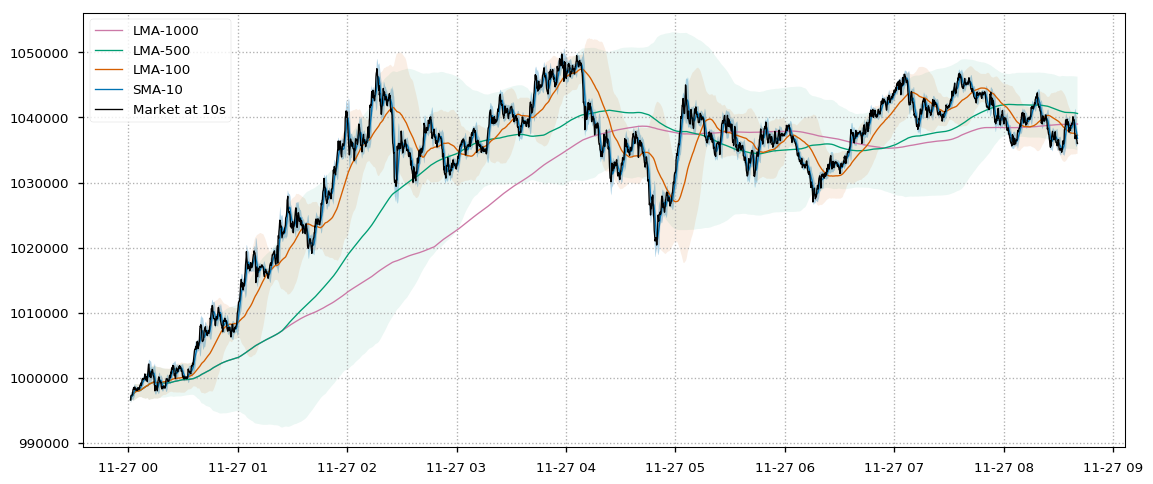

In [9]:
trades = asks

longlonglong_mean = trades['close'].rolling(window=1000, min_periods=1).mean()

longlong_mean = trades['close'].rolling(window=500, min_periods=1).mean()
longlong_std = trades['close'].rolling(window=500, min_periods=1).std()

long_mean = trades['close'].rolling(window=100, min_periods=1).mean()
long_std = trades['close'].rolling(window=100, min_periods=1).std()

short_mean = trades['close'].rolling(window=10, min_periods=1).mean()
short_std = trades['close'].rolling(window=10, min_periods=1).std()

long_slope = trades['close'].rolling(window=100, min_periods=1).apply(slope)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(longlonglong_mean.index, longlonglong_mean,
        color='m', lw=1,
        label='LMA-1000')

ax.fill_between(longlong_mean.index,
                longlong_mean + 2 * longlong_std,
                longlong_mean - 2 * longlong_std,
                lw=0, facecolor='g', alpha=0.08)
ax.plot(longlong_mean.index, longlong_mean,
        color='g', lw=1,
        label='LMA-500')

ax.fill_between(long_mean.index,
                long_mean + 2 * long_std,
                long_mean - 2 * long_std,
                lw=0, facecolor='r', alpha=0.1)
ax.plot(long_mean.index, long_mean,
        color='r', lw=1,
        label='LMA-100')

ax.fill_between(short_mean.index,
                short_mean + 2 * short_std,
                short_mean - 2 * short_std,
                lw=0, facecolor='b', alpha=0.3)
ax.plot(short_mean.index, short_mean,
        color='b', lw=1,
        label='SMA-10')

ax.plot(trades.index, trades['close'],
        color='k', lw=1,
        label=('Market at ' + bin_freq))

ax.legend()
ax.grid(True, ls=':')

pass

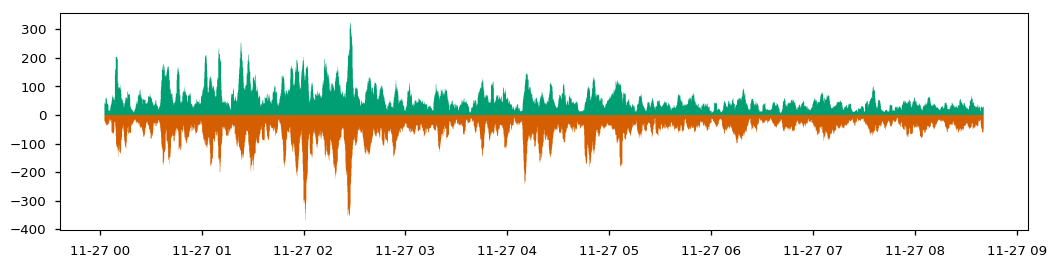

In [10]:
bid_amounts = bids['amount'].rolling(window=10).sum()
ask_amounts = asks['amount'].rolling(window=10).sum()

fig, ax = plt.subplots(figsize=(13, 3))

ax.fill_between(bid_amounts.index,  bid_amounts, lw=0, facecolor='g', step='pre')
ax.fill_between(ask_amounts.index, -ask_amounts, lw=0, facecolor='r', step='pre')

pass